# German Credit Card Classifier Project

In [1]:
FILE_NAME ="data/german_credit_card.csv"

In [2]:
# load and summarize the dataset
from pandas import read_csv
from collections import Counter
# define the dataset location
filename = FILE_NAME
# load the csv file as a data frame 
dataframe = read_csv(filename, header=None) 
# summarize the shape of the dataset 
print(dataframe.shape)
# summarize the class distribution
target = dataframe.values[:,-1]
counter = Counter(target)
for k,v in counter.items():
  per = v / len(target) * 100
  print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

(1000, 21)
Class=1, Count=700, Percentage=70.000%
Class=2, Count=300, Percentage=30.000%


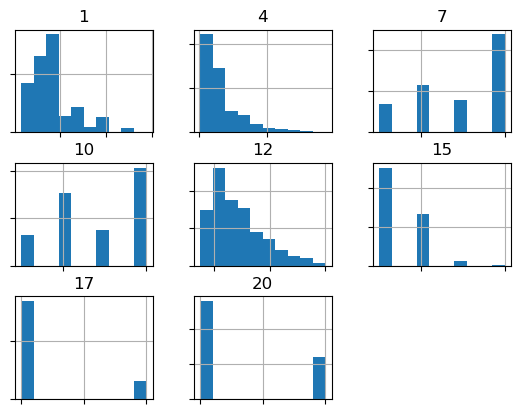

In [4]:
# create histograms of numeric input variables
from pandas import read_csv
from matplotlib import pyplot
# define the dataset location
filename = FILE_NAME
# load the csv file as a data frame
df = read_csv(filename, header=None)
# select columns with numerical data types
num_ix = df.select_dtypes(include=['int64', 'float64']).columns 
# select a subset of the dataframe with the chosen columns 
subset = df[num_ix]
# create a histogram plot of each numeric variable
ax = subset.hist()
# disable axis labels to avoid the clutter

for axis in ax.flatten():
  axis.set_xticklabels([])
  axis.set_yticklabels([])
# show the plot
pyplot.show()

### Cost(FalseNegatives) > Cost(FalsePositives)

In [5]:

# test harness and baseline model evaluation for the german credit dataset
from collections import Counter
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier

# load the dataset
def load_dataset(full_path):
  # load the dataset as a numpy array
  dataframe = read_csv(full_path, header=None)
  # split into inputs and outputs
  last_ix = len(dataframe.columns) - 1
  X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
  # select categorical features
  cat_ix = X.select_dtypes(include=['object', 'bool']).columns
  # one hot encode cat features only
  ct = ColumnTransformer([('o',OneHotEncoder(),cat_ix)], remainder='passthrough') 
  X = ct.fit_transform(X)
  # label encode the target variable to have the classes 0 and 1
  y = LabelEncoder().fit_transform(y)
  return X, y

  # calculate f2-measure
def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)


# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # define the model evaluation metric
  metric = make_scorer(f2_measure)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

# define the location of the dataset
full_path = FILE_NAME
# load the dataset
X, y = load_dataset(full_path)
# summarize the loaded dataset
print(X.shape, y.shape, Counter(y))
# define the reference model
model = DummyClassifier(strategy='constant', constant=1)
# evaluate the model
scores = evaluate_model(X, y, model)
# summarize performance
print('Mean F2: %.3f (%.3f)' % (mean(scores), std(scores)))

(1000, 61) (1000,) Counter({0: 700, 1: 300})
Mean F2: 0.682 (0.000)


### Evaluate Models

>LR 0.862 (0.033)
>LDA 0.855 (0.032)
>NB 0.679 (0.157)
>GPC 0.912 (0.014)
>SVM 0.885 (0.026)


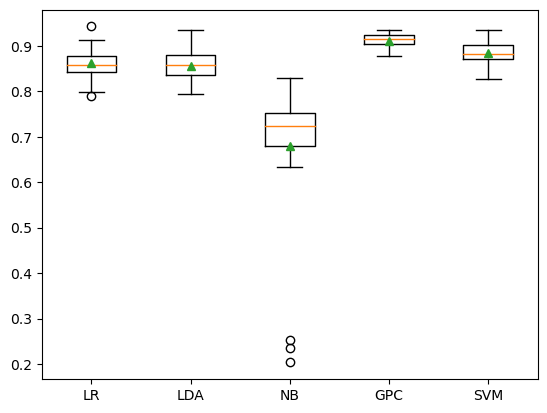

In [8]:
# spot check machine learning algorithms on the german credit dataset
from numpy import mean
from numpy import std
from pandas import read_csv
from matplotlib import pyplot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC


# load the dataset
def load_dataset(full_path):
  # load the dataset as a numpy array
  dataframe = read_csv(full_path, header=None)
  # split into inputs and outputs
  last_ix = len(dataframe.columns) - 1
  X, y = dataframe.drop(last_ix, axis=1), dataframe[last_ix]
  
  # select categorical and numerical features
  cat_ix = X.select_dtypes(include=['object', 'bool']).columns 
  num_ix = X.select_dtypes(include=['int64', 'float64']).columns # label encode the target variable to have the classes 0 and 1 y = LabelEncoder().fit_transform(y)
  return X.values, y, cat_ix, num_ix


# calculate f2-measure
def f2_measure(y_true, y_pred):
  return fbeta_score(y_true, y_pred, beta=2)

# evaluate a model
def evaluate_model(X, y, model):
  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
  # define the model evaluation metric
  metric = make_scorer(f2_measure)
  # evaluate model
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores


# define models to test
def get_models():
  models, names = list(), list()
  # LR 
  models.append(LogisticRegression(solver='liblinear')) 
  names.append('LR')
  # LDA
  models.append(LinearDiscriminantAnalysis()) 
  names.append('LDA')
  # NB
  models.append(GaussianNB())
  names.append('NB')
  # GPC
  models.append(GaussianProcessClassifier()) 
  names.append('GPC')
  # SVM
  models.append(SVC(gamma='scale'))
  names.append('SVM')
  return models, names

# define the location of the dataset
full_path = FILE_NAME
# load the dataset
X, y, cat_ix, num_ix = load_dataset(full_path) # define models
models, names = get_models()
results = list()
# evaluate each model
for i in range(len(models)):
  # one hot encode categorical, normalize numerical
  ct = ColumnTransformer([('c',OneHotEncoder(),cat_ix), ('n',MinMaxScaler(),num_ix)]) # wrap the model in a pipeline
  pipeline = Pipeline(steps=[('t',ct),('m',models[i])])
  # evaluate the model and store results
  scores = evaluate_model(X, y, pipeline)
  results.append(scores)
  # summarize and store
  print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))


# plot the results
pyplot.boxplot(results, labels=names, showmeans=True) 
pyplot.show()

### Evaluate Undersampling